In [2]:
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn import model_selection

In [6]:
plasticizers = pd.read_excel('../database/plasticizer_data_v4(rdkit_high_var).xls')
small_mols = pd.read_pickle('../database/gdb17_5mil.pkl')

In [7]:
plasticizers = plasticizers[plasticizers.columns[1:]]

In [8]:
rdkit_cols = plasticizers.columns[5:]
small_mols = small_mols[rdkit_cols]

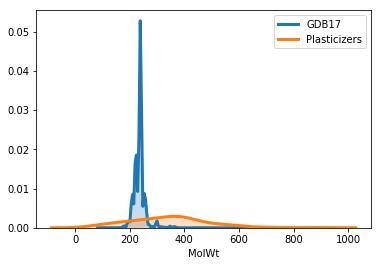

In [9]:
prop = 'MolWt'
sns.distplot(small_mols[prop], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label='GDB17')
sns.distplot(plasticizers[prop], hist=False, kde=True, kde_kws={'shade':True, 'linewidth':3}, label='Plasticizers')
plt.show()

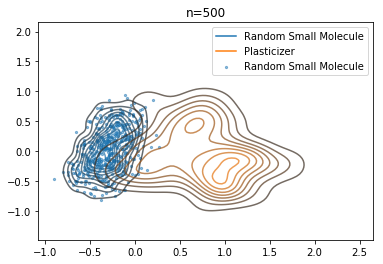

In [10]:
n=500
rdkit_cols_no_mw = list(set(rdkit_cols) - set(['MolWt']))
pca_data = plasticizers[rdkit_cols].to_numpy()
gdb_data = small_mols[rdkit_cols].sample(n=n).to_numpy()
joint_data = np.concatenate([pca_data, gdb_data], axis=0)

scaler = MinMaxScaler()
joint_data = scaler.fit_transform(joint_data)

joint_pca = PCA(n_components=2)
joint_pca.fit(joint_data)
joint_ics = joint_pca.transform(joint_data)

sns.kdeplot(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.7)
sns.kdeplot(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.7)
plt.scatter(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.5, s=5)
plt.legend(loc='best')
plt.title('n={}'.format(n))
plt.show()

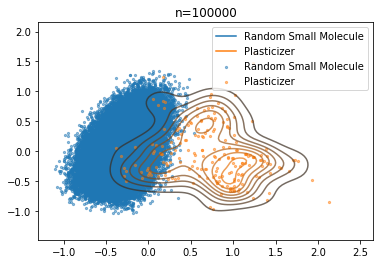

In [11]:
n=100000
gdb_test_sample = small_mols[rdkit_cols].sample(n=n).to_numpy()

gdb_test_sample = scaler.transform(gdb_test_sample)
test_ics = joint_pca.transform(gdb_test_sample)

sns.kdeplot(joint_ics[204:,0], joint_ics[204:,1], label='Random Small Molecule', alpha=0.0)
sns.kdeplot(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.7)
plt.scatter(test_ics[:,0], test_ics[:,1], label='Random Small Molecule', alpha=0.5, s=5)
plt.scatter(joint_ics[:204,0], joint_ics[:204,1], label='Plasticizer', alpha=0.5, s=5)
plt.legend(loc='best')
plt.title('n={}'.format(n))
plt.show()

# Investigating the Kernel Density Estimation as Plasticizer-Likelihood Function

In [84]:
def calc_kde(xis, lo, hi, h=0.17):
    kde = []
    xs = np.linspace(lo, hi, 101)
    for x in xs:
        kde_sum = 0
        for xi in xis:
            x_prime = (x - xi) / h
            kde_sum += 1 / (1 * math.sqrt(2*math.pi))*math.exp(-(1/2)*((x_prime - 0) / 1)**2)
        kde_sum /= len(xis)*h
        kde.append(kde_sum)
    return kde, xs

def eval_acc(vs, boundary):
    hits = 0
    for v in vs:
        if v > boundary:
            hits += 1
        else:
            pass
    acc = hits / len(vs)
    return acc

def calc_2D_kde(x_vec, x_range, y_range, gridsize=101):
    # Using Scott's rule of thumb
    d = 2
    std_i = np.std(x_vec[:,0])
    std_j = np.std(x_vec[:,1])
    n = x_vec.shape[0]
    H_i = (n**(-1 / (d + 4))*std_i)**2
    H_j = (n**(-1 / (d + 4))*std_j)**2
    H = np.array([[H_i, 0], [0, H_j]])
    
    xs = np.linspace(x_range[0], x_range[1], gridsize)
    ys = np.linspace(y_range[0], y_range[1], gridsize)
    kde = np.zeros((gridsize, gridsize))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            kde_sum = 0
            for k in range(x_vec.shape[0]):
                xi = x_vec[k,:]
                x_prime = np.array([x, y]) - xi
                val = (2*math.pi)**(-d/2)*(np.linalg.det(H))**(-1/2)*math.exp(-(1/2)*x_prime.T@np.linalg.inv(H)@x_prime)
                kde_sum += val
            kde_sum /= n
            kde[i,j] = kde_sum
    return kde.T, xs, ys

def get_kde_value(v, kde, xs):
    for i, x in enumerate(xs):
        if v < x:
            idx = i
            break
    val = kde[i]
    return val

def get_2D_kde_value(v, kde, xs, ys):
    idxs = []
    for i, x in enumerate(xs):
        if v[0] < x:
            idxs.append(i)
            break
    for j, y in enumerate(ys):
        if v[1] < y:
            idxs.append(j)
            break
    val = kde.T[idxs[0], idxs[1]]
    return val

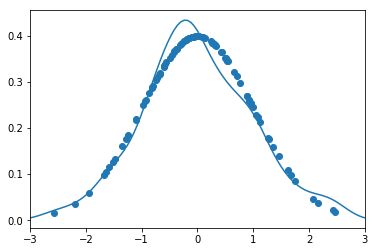

In [13]:
#Understanding KDE on Normal Distribution
mu = 0
sigma = 1
n = 100
xis = np.random.normal(mu, sigma, n)
ys = []
for xi in xis:
    y = 1 / (sigma * math.sqrt(2*math.pi))*math.exp(-(1/2)*((xi - mu) / sigma)**2)
    ys.append(y)

kde, xs = calc_kde(xis, -3, 3, h=0.3)
plt.plot(xs, kde)
plt.scatter(xis, ys)
plt.xlim([-3,3])
plt.show()
    


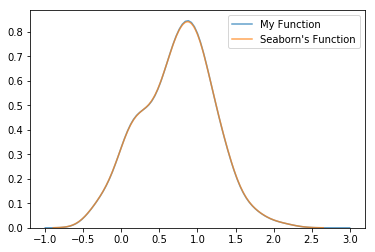

In [14]:
#Building 1D KDE for 1st PCA Component
xis = joint_ics[:204,0]
kde, xs = calc_kde(xis, -1, 3)

plt.plot(xs, kde, label='My Function', alpha=0.7)
sns.kdeplot(xis, label='Seaborn\'s Function', alpha=0.7)
plt.show()

In [104]:
#Building 2D KDE for 1st 2 PCA Components
kde, xs, ys = calc_2D_kde(X_ics, [-1.5, 2.5], [-1.5, 2.0], gridsize=101)

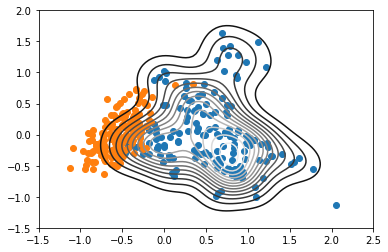

In [105]:
plt.contour(xs, ys, kde, levels=15, cmap='gray')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()

In [106]:
pl_test_kdes = []
pl_train_kdes = []
gdb_kdes = []
for pl_sample in X_test_ics:
    try:
        pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
    except IndexError:
        pass
for pl_sample in X_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for gdb_sample in y_test_ics:
    gdb_kdes.append(get_2D_kde_value(gdb_sample, kde, xs, ys))

In [107]:
boundary = 0.2
X_train_acc_2d_kde = eval_acc(pl_train_kdes, boundary)
X_test_acc_2d_kde = eval_acc(pl_test_kdes, boundary)
y_test_acc_2d_kde = eval_acc(gdb_kdes, boundary)
print("Train Accuracy - {}%".format(round(X_train_acc_2d_kde*100, 2)))
print("Test Accuracy - {}%".format(round(X_test_acc_2d_kde*100, 2)))
print("GDB Hit Percent - {}% ({} / {} samples)".format(round(y_test_acc_2d_kde*100, 2), int(y_test_acc_2d_kde*len(gdb_kdes)), len(gdb_kdes)))

Train Accuracy - 77.44%
Test Accuracy - 74.36%
GDB Hit Percent - 11.01% (37 / 336 samples)


In [108]:
kde, xs = calc_kde(X_ics[:,0], -1.5, 2.5)

In [109]:
pl_test_kdes = []
pl_train_kdes = []
gdb_kdes = []
for pl_sample in X_test_ics[:,0]:
    try:
        pl_test_kdes.append(get_kde_value(pl_sample, kde, xs))
    except IndexError:
        pass
for pl_sample in X_ics[:,0]:
    pl_train_kdes.append(get_kde_value(pl_sample, kde, xs))
for gdb_sample in y_test_ics[:,0]:
    gdb_kdes.append(get_kde_value(gdb_sample, kde, xs))

In [119]:
boundary = 0.2
X_train_acc_1d_kde = eval_acc(pl_train_kdes, boundary)
X_test_acc_1d_kde = eval_acc(pl_test_kdes, boundary)
y_test_acc_1d_kde = eval_acc(gdb_kdes, boundary)
print("Train Accuracy - {}%".format(round(X_train_acc_1d_kde*100, 2)))
print("Test Accuracy - {}%".format(round(X_test_acc_1d_kde*100, 2)))
print("GDB Hit Percent - {}% ({} / {} samples)".format(round(y_test_acc_1d_kde*100, 2), int(y_test_acc_1d_kde*len(gdb_kdes)), len(gdb_kdes)))

Train Accuracy - 93.29%
Test Accuracy - 90.0%
GDB Hit Percent - 22.32% (75 / 336 samples)


In [ ]:
test_small_mols = small_mols[rdkit_cols].sample(n=10000).to_numpy()

test_small_mols = scaler.transform(test_small_mols)

test_ics = joint_pca.transform(test_small_mols)

In [ ]:
train_small_mols = joint_ics[204:,:2]
test_small_mols = test_ics[:,:2]
train_plast = joint_ics[:204,:2]
train_plast_lls = []
train_small_mol_lls = []
test_small_mol_lls = []
for i in range(train_plast.shape[0]):
    ll = get_kde_value(train_plast[i,:], kde, xs, ys)
    train_plast_lls.append(ll)
for i in range(train_small_mols.shape[0]):
    ll = get_kde_value(train_small_mols[i,:], kde, xs, ys)
    train_small_mol_lls.append(ll)
for i in range(test_small_mols.shape[0]):
    ll = get_kde_value(test_small_mols[i,:], kde, xs, ys)
    test_small_mol_lls.append(ll)
sns.distplot(train_plast_lls, hist=False, kde=True, label='Plasticizer')
sns.distplot(train_small_mol_lls, hist=False, kde=True, label='GDB')
sns.distplot(test_small_mol_lls, hist=False, kde=True, label='Test GDB Sample')
plt.show()

### Validation

# One-Class Classification

In [17]:
## No PCA
X = plasticizers[rdkit_cols].to_numpy()
X_prime = small_mols[rdkit_cols].sample(n=500).to_numpy()

clf = OneClassSVM()
clf.fit(X)
X_scores = clf.score_samples(X)
X_prime_scores = clf.predict(X_prime)

/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


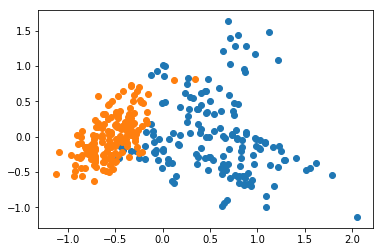

In [101]:
## PCA
X = plasticizers[rdkit_cols].to_numpy()
rand_idxs = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
train_idxs = rand_idxs[:164]
test_idxs = rand_idxs[164:]
X_train = X[train_idxs,:]
X_test = X[test_idxs,:]

y = small_mols[rdkit_cols].sample(n=500).to_numpy()
rand_idxs = np.random.choice(np.arange(len(y)), size=len(y), replace=False)
pca_idxs = rand_idxs[:164]
test_idxs = rand_idxs[164:]
y_pca = y[pca_idxs,:]
y_test = y[test_idxs,:]

joint_data = np.concatenate([X_train, y_pca], axis=0)
test_data = np.concatenate([X_test, y_test], axis=0)

scaler = MinMaxScaler()
joint_data = scaler.fit_transform(joint_data)
test_data = scaler.transform(test_data)

joint_pca = PCA(n_components=2)
joint_pca.fit(joint_data)
joint_ics = joint_pca.transform(joint_data)
test_ics = joint_pca.transform(test_data)
X_ics = joint_ics[:164,:]
y_ics = joint_ics[164:,:]
X_test_ics = test_ics[:40,:]
y_test_ics = test_ics[40:,:]


plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()

/Users/prguser/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


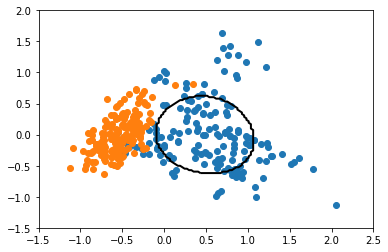

0.5 0.425 0.002976190476190476


In [102]:
## OneClassSVM

clf = OneClassSVM()
clf.fit(X_ics)
xx, yy = np.meshgrid(np.linspace(-1.5,2.5,150),
                     np.linspace(-1.5,2.0,150))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()


y_scores = clf.score_samples(y_ics)
X_predict = clf.predict(X_ics)
X_test_predict = clf.predict(X_test_ics)
y_test_predict = clf.predict(y_test_ics)
pos_y_test = 0
for val in y_test_predict:
    if val == 1:
        pos_y_test += 1

pos_X_train = 0
for val in X_predict:
    if val == 1:
        pos_X_train += 1
        
pos_X_test = 0
for val in X_test_predict:
    if val == 1:
        pos_X_test += 1
y_test_acc_svm = pos_y_test / len(y_test_predict)
X_train_acc_svm = pos_X_train / len(X_predict)
X_test_acc_svm = pos_X_test / len(X_test_predict)
print(X_train_acc_svm, X_test_acc_svm, y_test_acc_svm)

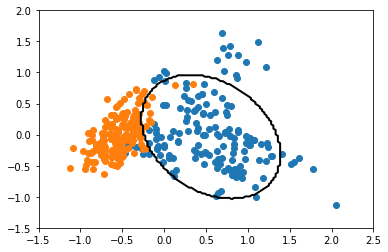

0.7987804878048781 0.75 0.07738095238095238


In [103]:
## Robust Covariance

clf = EllipticEnvelope(contamination=0.2)
clf.fit(X_ics)
xx, yy = np.meshgrid(np.linspace(-1.5,2.5,150),
                     np.linspace(-1.5,2.0,150))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X_ics[:,0], X_ics[:,1])
plt.scatter(y_ics[:,0], y_ics[:,1])
plt.show()

y_scores = clf.score_samples(y_ics)
X_predict = clf.predict(X_ics)
X_test_predict = clf.predict(X_test_ics)
y_test_predict = clf.predict(y_test_ics)
pos_y_test = 0
for val in y_test_predict:
    if val == 1:
        pos_y_test += 1

pos_X_train = 0
for val in X_predict:
    if val == 1:
        pos_X_train += 1
        
pos_X_test = 0
for val in X_test_predict:
    if val == 1:
        pos_X_test += 1
y_test_acc_rc = pos_y_test / len(y_test_predict)
X_train_acc_rc = pos_X_train / len(X_predict)
X_test_acc_rc = pos_X_test / len(X_test_predict)
print(X_train_acc_rc, X_test_acc_rc, y_test_acc_rc)

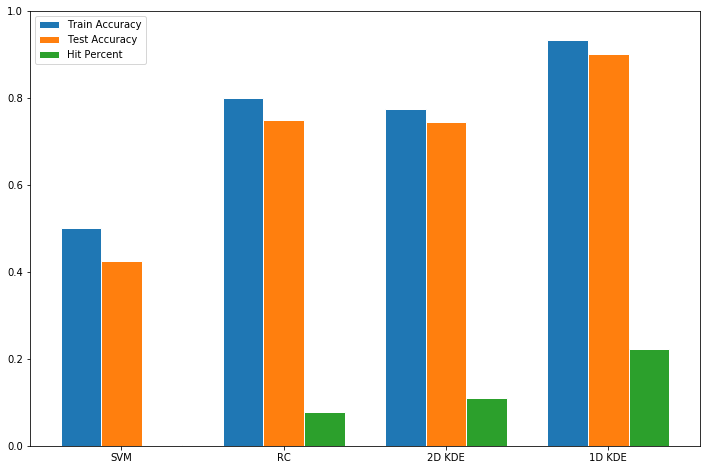

In [120]:
train_accs = [X_train_acc_svm, X_train_acc_rc, X_train_acc_2d_kde, X_train_acc_1d_kde]
test_accs = [X_test_acc_svm, X_test_acc_rc, X_test_acc_2d_kde, X_test_acc_1d_kde]
hit_percent = [y_test_acc_svm, y_test_acc_rc, y_test_acc_2d_kde, y_test_acc_1d_kde]

barwidth = 0.25

r1 = np.arange(len(train_accs))
r2 = [x + barwidth for x in r1]
r3 = [x + barwidth for x in r2]

fig = plt.figure(figsize=(12,8))
plt.bar(r1, train_accs, width=barwidth, edgecolor='white', label='Train Accuracy')
plt.bar(r2, test_accs, width=barwidth, edgecolor='white', label='Test Accuracy')
plt.bar(r3, hit_percent, width=barwidth, edgecolor='white', label='Hit Percent')
plt.xticks([r + barwidth for r in range(len(train_accs))], ['SVM', 'RC', '2D KDE', '1D KDE'])
plt.legend(loc='best')
plt.ylim([0,1])
plt.show()